In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import nbinom

warnings.filterwarnings("ignore")

## Synthetic gene expression generation

In [2]:
# Parameters
n_cells = 10000
n_genes = 20
target_zero_prob = 0.8  # Desired overall zero probability

# Simulate gene-specific parameters
np.random.seed(42)
mu_values = np.random.uniform(1, 10, n_genes)         # Mean of NB
theta_values = np.random.uniform(0.5, 2.0, n_genes)   # Dispersion 

# Initialize gene expression matrix
x = np.zeros((n_cells, n_genes), dtype=int)

pi_values = []
# Fill the matrix with ZINB simulated data, solving for pi to match target zero probability
for j in range(n_genes):
    mu = mu_values[j]
    r = 1 / theta_values[j]  

    # Scipy-compatible NB probability
    p = r / (r + mu)

    # Compute probability of zero from NB
    p_nb_zero = nbinom.pmf(0, r, p)

    # Solve for pi to match target overall zero probability
    pi = (target_zero_prob - p_nb_zero) / (1 - p_nb_zero)
    pi = np.clip(pi, 0, 1)  # Ensure it's within [0,1]
    pi_values.append(pi)

    # Simulate NB samples
    nb_samples = nbinom.rvs(r, p, size=n_cells)

    # Apply zero-inflation
    zero_mask = np.random.binomial(1, pi, size=n_cells)
    nb_samples[zero_mask == 1] = 0

    x[:, j] = nb_samples

pi_values = np.array(pi_values)

# Convert to DataFrame
gene_names = [f"Gene_{i+1}" for i in range(n_genes)]
cell_names = [f"Cell_{i+1}" for i in range(n_cells)]
expression_df = pd.DataFrame(x, index=cell_names, columns=gene_names)

# Check actual zero proportion
actual_zero_rate = (x == 0).sum() / x.size
print(f"Actual overall zero proportion: {actual_zero_rate:.4f}")

Actual overall zero proportion: 0.7997


## ! Add systematic batch effect on 1/2 of cells


In [3]:
adata = sc.AnnData(X=x)
adata.obs['batch'] = 0
adata.obs["batch"].iloc[:n_cells//2] = 1
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'batch'

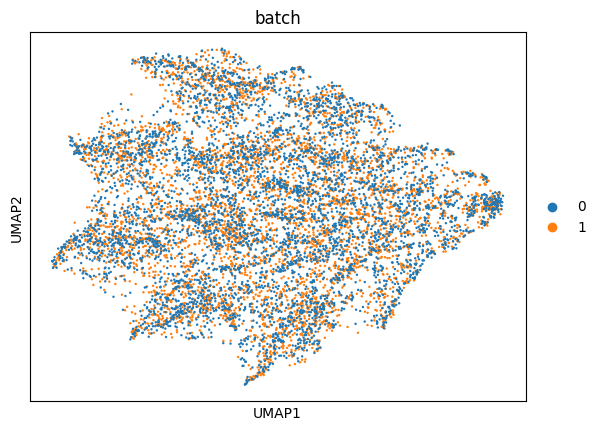

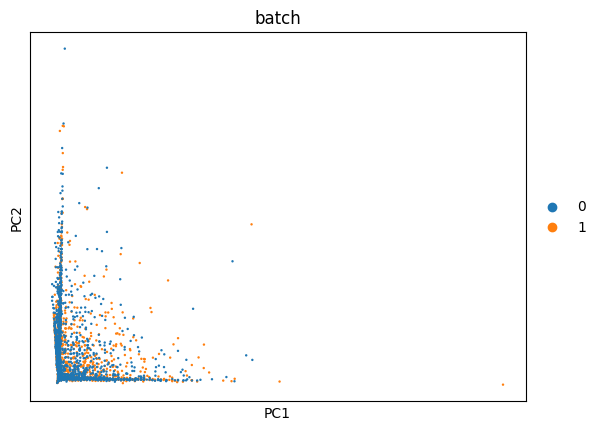

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.pca(adata)
sc.pl.umap(adata, color='batch')
sc.pl.pca(adata, color='batch')

In [5]:
x[:n_cells//2,:] += 10
#x *= mask
x

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 14, 10],
       [17, 10, 10, ..., 10, 10, 10],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 6,  0,  3, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0]])

In [6]:
adata = sc.AnnData(X=x)
adata.obs['batch'] = 0
adata.obs["batch"].iloc[:n_cells//2] = 1
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'batch'

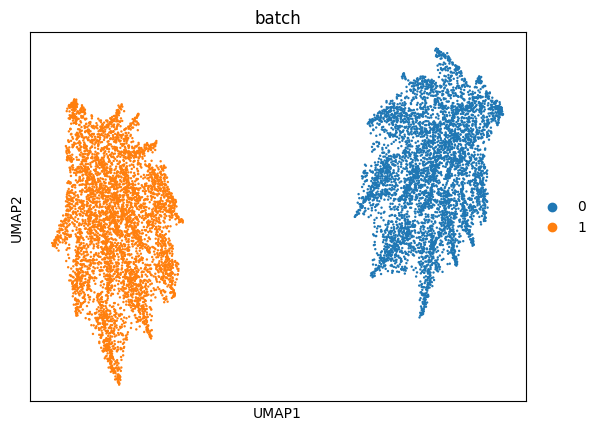

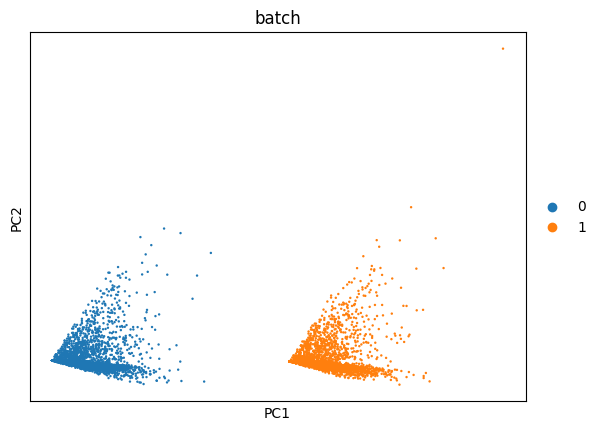

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.pca(adata)
sc.pl.umap(adata, color='batch')
sc.pl.pca(adata, color='batch')

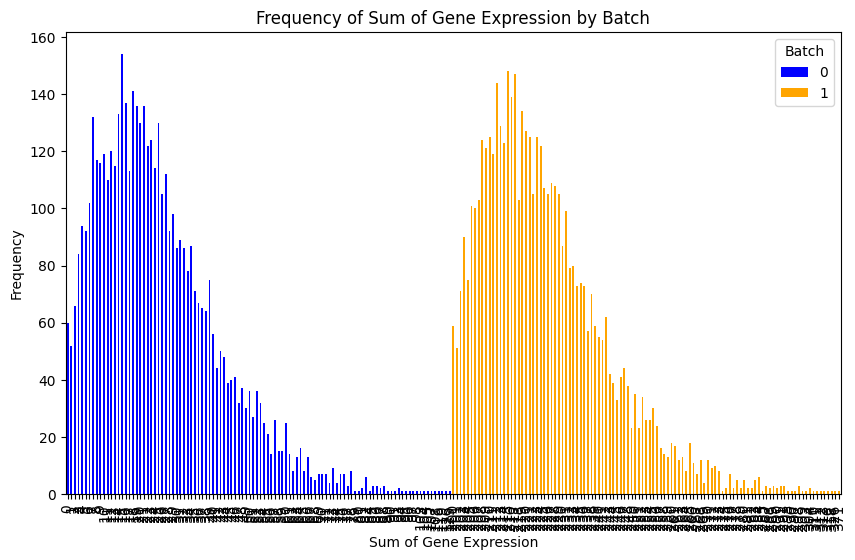

In [8]:
adata.obs["sum_expression"] = adata.X.sum(axis=1)
sum_counts_batch = adata.obs.groupby(["sum_expression", "batch"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["blue", "orange"]  # Assuming two batches: 0 and 1
sum_counts_batch.plot(kind="bar", stacked=True, color=colors, ax=ax)

ax.set_xlabel("Sum of Gene Expression")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of Sum of Gene Expression by Batch")
plt.legend(title="Batch")
plt.show()

## Architecture and loss definition

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# ZINB LOSS FUNCTION
# ----------------------------
class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda

    def forward(self, x, mean, dispersion, pi, scale_factor=1.0):
        x = x.float()
        mean = mean * scale_factor

        nb_case = (
            torch.lgamma(dispersion + self.eps)
            + torch.lgamma(x + 1.0)
            - torch.lgamma(x + dispersion + self.eps)
            - dispersion * torch.log(dispersion + self.eps)
            - x * torch.log(mean + self.eps)
            + (dispersion + x) * torch.log(dispersion + mean + self.eps)
        )

        zero_case = -torch.log(pi + ((1.0 - pi) * torch.exp(-nb_case)) + self.eps)

        result = torch.where(torch.lt(x, 1e-8), zero_case, -torch.log(1.0 - pi + self.eps) + nb_case)
        ridge = self.ridge_lambda * (pi ** 2).sum()

        return result.mean() + ridge

# ----------------------------
# ENCODER
# ----------------------------

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# ----------------------------
# DECODER (Conditional on Batch)
# ----------------------------

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_batches):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + n_batches, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_disp = nn.Linear(hidden_dim, output_dim)
        self.fc_pi = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, batch_onehot):
        z_cond = torch.cat([z, batch_onehot], dim=-1)
        h = F.relu(self.fc1(z_cond))
        h = F.relu(self.fc2(h))
        mean = F.relu(self.fc_mean(h))
        dispersion = F.relu(self.fc_disp(h))
        pi = torch.sigmoid(self.fc_pi(h))
        return mean, dispersion, pi


# ----------------------------
# VAE MODULE
# ----------------------------
class ZINBVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_batches):
        super(ZINBVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_batches)
        self.zinb_loss_fn = ZINBLoss()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, batch_onehot):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        mean, disp, pi = self.decoder(z, batch_onehot)
        return mean, disp, pi, mu, logvar, z

    def loss_function(self, x, mean, disp, pi, mu, logvar):
        zinb_loss = self.zinb_loss_fn(x, mean, disp, pi)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return zinb_loss + 1e-8 * kl_div


## Set seed and training loop

No dataloader for simplicity

In [94]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False



In [24]:
true_mu_tensor = torch.tensor(np.tile(mu_values, (n_cells, 1)) , dtype=torch.float32)
true_theta_tensor = torch.tensor(np.tile(theta_values, (n_cells, 1)), dtype=torch.float32)
true_pi_tensor = torch.tensor(np.tile(pi_values, (n_cells, 1)), dtype=torch.float32)

In [95]:
# Set the seed
set_seed(11)
vae = ZINBVAE(input_dim=n_genes, hidden_dim=30, latent_dim=5, n_batches=2)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
x = torch.tensor(x, dtype=torch.float32)
batch_onehot = F.one_hot(torch.tensor(adata.obs["batch"], dtype=torch.long), num_classes=2)

vae.train()
for epoch in range(1000):
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x, batch_onehot)
    batch_loss = F.mse_loss(mu[:n_cells//2,:], mu[n_cells//2:,:])
    batch_loss += F.mse_loss(logvar[:n_cells//2,:], logvar[n_cells//2:,:])
    batch_loss *= 1e-2
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    loss += batch_loss
    loss.backward()
    optimizer.step()
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    with torch.no_grad():
        if epoch == 0:
            mean_mse = F.mse_loss(mean, true_mu_tensor).item()
            theta_mse = F.mse_loss(disp, true_theta_tensor).item()
            pi_mse = F.mse_loss(pi, true_pi_tensor).item()
    
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Mean MSE: {mean_mse:.4f}, Theta MSE: {theta_mse:.4f}, Pi MSE: {pi_mse:.4f}")
    
    if epoch>0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 49.3591, Mean MSE: 32.6283, Theta MSE: 1.4115, Pi MSE: 0.0633
Epoch 1, Loss: 45.8014
Epoch 2, Loss: 43.2024
Epoch 3, Loss: 40.5172
Epoch 4, Loss: 38.2863
Epoch 5, Loss: 36.5221
Epoch 6, Loss: 34.5902
Epoch 7, Loss: 32.9831
Epoch 8, Loss: 31.2493
Epoch 9, Loss: 29.7819
Epoch 10, Loss: 28.4909
Epoch 11, Loss: 27.2426
Epoch 12, Loss: 26.0328
Epoch 13, Loss: 25.0156
Epoch 14, Loss: 23.7347
Epoch 15, Loss: 22.6918
Epoch 16, Loss: 21.8509
Epoch 17, Loss: 20.8191
Epoch 18, Loss: 19.9634
Epoch 19, Loss: 19.2879
Epoch 20, Loss: 18.6761
Epoch 21, Loss: 18.1834
Epoch 22, Loss: 17.8506
Epoch 23, Loss: 17.3496
Epoch 24, Loss: 16.9536
Epoch 25, Loss: 16.7403
Epoch 26, Loss: 16.3734
Epoch 27, Loss: 16.0837
Epoch 28, Loss: 15.7470
Epoch 29, Loss: 15.3952
Epoch 30, Loss: 15.0446
Epoch 31, Loss: 14.6247
Epoch 32, Loss: 14.2539
Epoch 33, Loss: 13.9594
Epoch 34, Loss: 13.6737
Epoch 35, Loss: 13.3928
Epoch 36, Loss: 13.1099
Epoch 37, Loss: 12.9151
Epoch 38, Loss: 12.7675
Epoch 39, Loss: 12.5

Epoch 999, Loss: 5.8603, Mean MSE: 20.5698, Theta MSE: 71.5955, Pi MSE: 0.3440


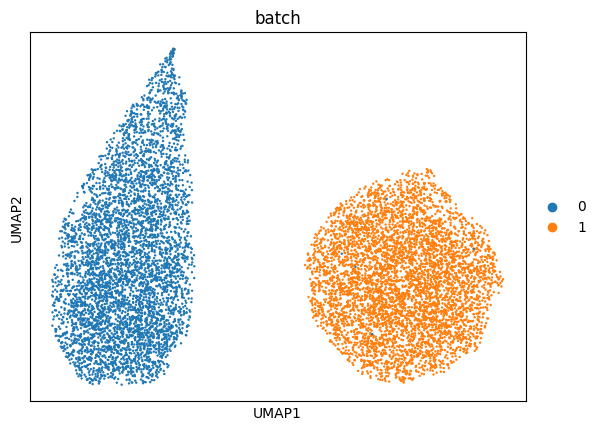

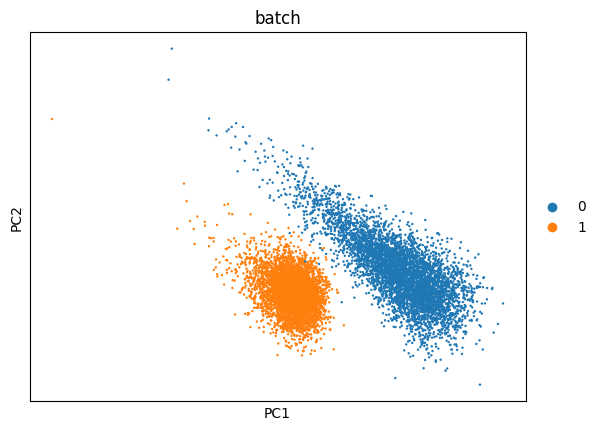

In [96]:
# Set the seed
set_seed(11)

batch_onehot_new = torch.tile(batch_onehot[-1], (n_cells, 1))

vae.eval()
with torch.no_grad():
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x, batch_onehot)
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    mean_mse = F.mse_loss(mean, true_mu_tensor).item()
    theta_mse = F.mse_loss(disp, true_theta_tensor).item()
    pi_mse = F.mse_loss(pi, true_pi_tensor).item()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Mean MSE: {mean_mse:.4f}, Theta MSE: {theta_mse:.4f}, Pi MSE: {pi_mse:.4f}")


adata.obsm["z"] = z.detach().numpy()
adata.obsm["mean"] = mean.detach().numpy()
adata.obsm["dispersion"] = disp.detach().numpy()
adata.obsm["pi"] = pi.detach().numpy()

sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

adata_test = sc.AnnData(X=z.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch')

In [97]:
"""import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(x.sum(1), label='Input', color='blue', stat='density', kde=True, bins=50, alpha=0.5)
sns.histplot(adata.obsm["zinb_output"].sum(1), label='Decoder Output', color='orange', stat='density', kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Counts per Cell")
plt.ylabel("Density")
plt.title("Distribution of Total Counts per Cell")
plt.legend()
plt.tight_layout()
plt.show()
"""

'import seaborn as sns\n\nplt.figure(figsize=(8, 5))\nsns.histplot(x.sum(1), label=\'Input\', color=\'blue\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nsns.histplot(adata.obsm["zinb_output"].sum(1), label=\'Decoder Output\', color=\'orange\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nplt.xlabel("Total Counts per Cell")\nplt.ylabel("Density")\nplt.title("Distribution of Total Counts per Cell")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [98]:
def sample_zinb(mean, disp, pi, eps=1e-8):
    """
    Sample counts from a Zero-Inflated Negative Binomial distribution.

    Parameters:
        mean: Tensor [n_cells, n_genes]
        disp: Tensor [n_cells, n_genes]
        pi:   Tensor [n_cells, n_genes]

    Returns:
        samples: Tensor [n_cells, n_genes]
    """
    # Ensure tensors are on the same device
    mean, disp, pi = mean.to(torch.float32), disp.to(torch.float32), pi.to(torch.float32)

    # Compute NB parameters
    p = mean / (mean + disp + eps)  # success probability
    r = disp  # number of failures

    # Gamma-Poisson sampling trick for NB
    gamma_sample = torch._standard_gamma(r)
    nb_sample = torch.poisson(gamma_sample * (p / (1 - p + eps)))

    # Apply zero inflation
    keep_mask = torch.bernoulli(1.0 - pi)  # 1 = keep, 0 = zero-inflate
    zinb_sample = nb_sample * keep_mask

    return zinb_sample

set_seed(11)
zinb_sample = sample_zinb(mean, disp, pi)
zinb_sample

tensor([[15.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4., 50.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  8.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

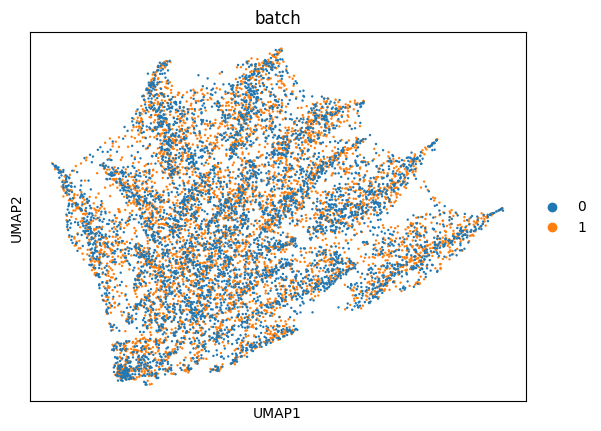

In [99]:
adata.obsm["zinb_sample"] = zinb_sample.detach().numpy()

sc.pp.neighbors(adata, use_rep="zinb_sample")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')


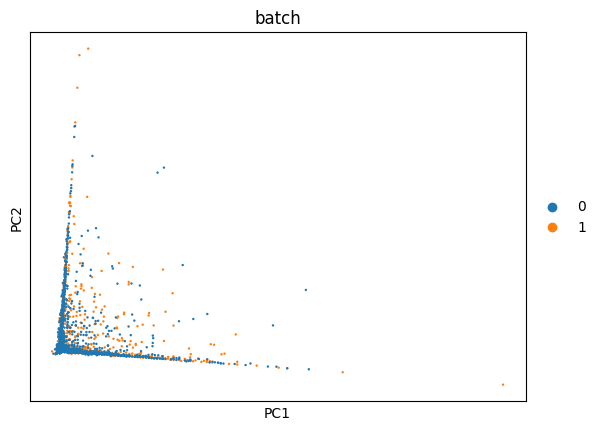

In [100]:
adata_test = sc.AnnData(X=zinb_sample.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch', layer="z")

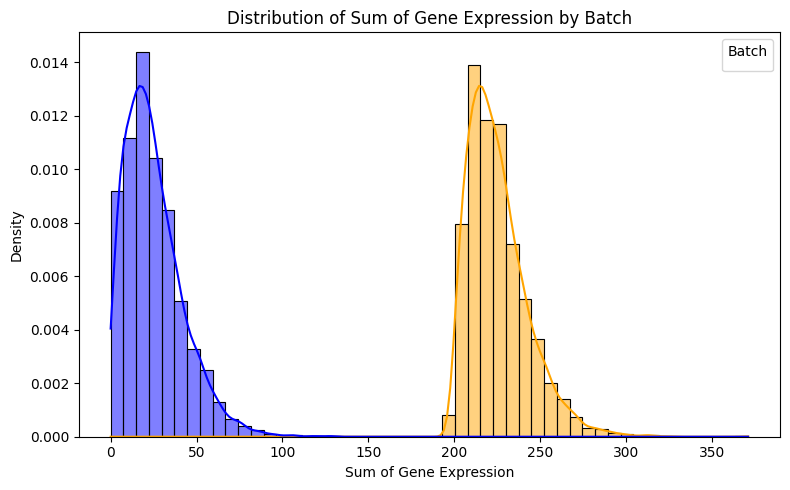

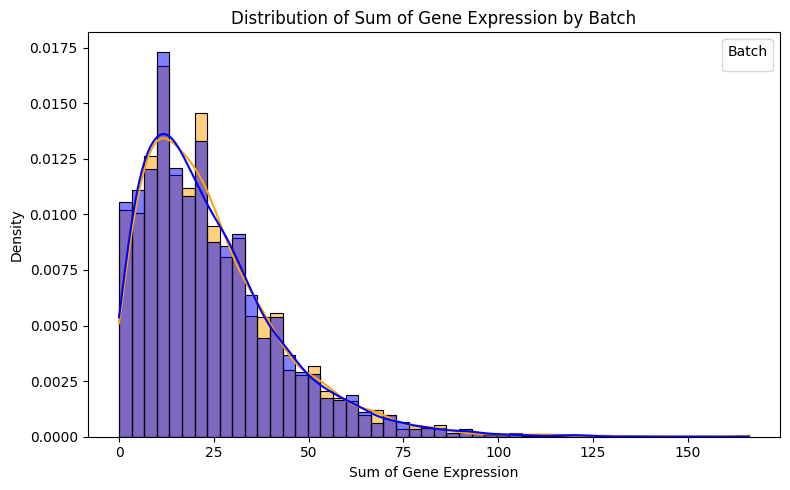

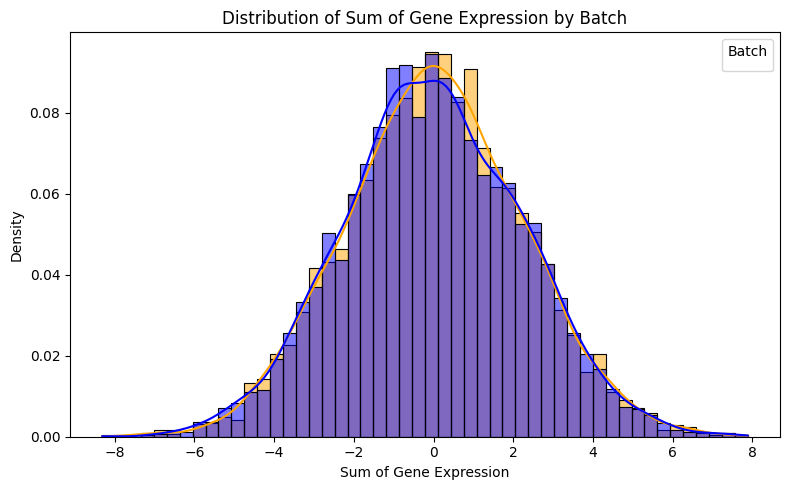

In [101]:
# Convert the sum of gene expression to a pandas DataFrame for plotting
adata.obs["sum_expression"] = adata.X.sum(1)  # Ensure sum_expression is in obs
adata.obs["z"] = adata.obsm["z"].sum(1)
adata.obs["mean"] = adata.obsm["mean"].sum(1)
adata.obs["zinb_sample"] = adata.obsm["zinb_sample"].sum(1)


for key in ["sum_expression", "zinb_sample", "z"]:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=adata.obs, x=key, hue="batch", palette=colors, stat="density", kde=True, bins=50, alpha=0.5)
    plt.xlabel("Sum of Gene Expression")
    plt.ylabel("Density")
    plt.title("Distribution of Sum of Gene Expression by Batch")
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

In [102]:
loss

tensor(3.4054)